<a href="https://colab.research.google.com/github/jugash/Tools/blob/master/storypoints_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation

In [ ]:
# !pip install np
# !pip install pd
# !pip install nltk
# !pip install gensim
# !pip install --upgrade tensorflow
!pip install simpletransformers
!pip install wandb -q

In [ ]:
%cd /content/drive/MyDrive/DataScience/MSC/Project1/

/content/drive/MyDrive/DataScience/MSC/Project1


In [ ]:
import numpy as np
import pandas as pd
import nltk
from gensim.models import Word2Vec
from gensim.models import FastText
from nltk import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
from keras.models import Sequential, Model
from keras import layers
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from nltk.corpus import stopwords
from datetime import datetime
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

2021-07-29 21:37:15.639556: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
column = 'td'
embedding_dim=300
maxlen=150
mname=f'models/OS_{column}_20210724'

nltk.download('punkt')

LABELS=['Trivial','Minor','Medium', 'Major', 'Huge','Enormous','Epic']
PROJECTS = ['appcelerator', 'aptanastudio', 'bamboo', 'clover', 'datamanagement', 'duracloud', 'jirasoftware', 'mesos', 'mule', 'mulestudio', 'springxd', 'talendesb', 'titanium']

PRETRAIN = ['apache_pretrain', 'jira_pretrain', 'spring_pretrain', 'talendforge_pretrain', 
            'moodle_pretrain', 'appcelerator_pretrain', 'duraspace_pretrain', 'mulesoft_pretrain', 'lsstcorp_pretrain']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data Load

In [ ]:
for prj in PROJECTS:
  if not os.path.exists(f'{prj}.csv'):
    !wget https://raw.githubusercontent.com/SEAnalytics/datasets/master/storypoint/IEEE%20TSE2018/Deep-SE/data/{prj}.csv


In [ ]:
for prj in PRETRAIN:
  if not os.path.exists(f'{prj}.csv'):
    !wget https://raw.githubusercontent.com/SEAnalytics/datasets/master/storypoint/IEEE%20TSE2018/Deep-SE/data/{prj}.csv

In [ ]:
def load_files(projects=PROJECTS):
  dfs = []
  for prj in projects:
    df=pd.read_csv(f'{prj}.csv')
    df['project'] = prj
    dfs.append(df)
    
  return pd.concat(dfs)

In [ ]:
df=load_files(projects=PROJECTS)
df=df.loc[df['storypoint'] < 20.5]
df=df.dropna()
df['td'] = df['title'] + df['description']
df=df[['td', 'storypoint']].copy()
df

,td,storypoint
0,Load event image Bug on 4.0.0.RC3 IOSEvent lis...,3
1,iOS Ti.Contacts removePerson + save crashesWit...,3
2,Android: Titanium.UI.Tab onFocus and onBlur ev...,1
3,"Emulator not running, exiting...I am running d...",10
4,I am trying to call webservices file in our Ap...,12
...,...,...
2246,"iOS Media.showCamera ""Temp"" file issueh6. Issu...",2
2247,iOS: close() is applied to multiple window vie...,3
2248,Windows: Implement Titanium.Network.SocketImpl...,8
2249,Hyperloop: Android aar without asset folder fa...,1


In [ ]:
df['complexity'] = pd.cut(df['storypoint'], bins=[0.5,1.5,2.5,3.5,5.5,8.5,13.5,20.5], labels=list(range(len(LABELS))))
labels = df['complexity'].values
sentences = df[column].values
type(labels)

pandas.core.arrays.categorical.Categorical

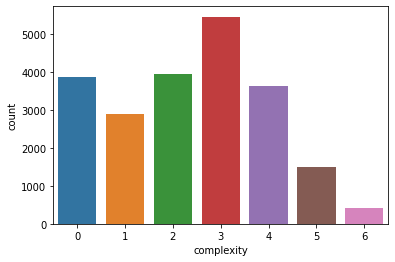

In [ ]:
sns.countplot(data=df, x='complexity')

# Class Imbalance

In [ ]:
from imblearn.over_sampling import RandomOverSampler

X=df['td'].to_numpy()

sampler = RandomOverSampler(random_state=0)
RS=sampler.fit_resample(X.reshape(-1,1), df['complexity'])
sentences=pd.Series(RS[0].reshape(-1), name=column).values
labels=pd.Series(RS[1], name='complexity').values

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


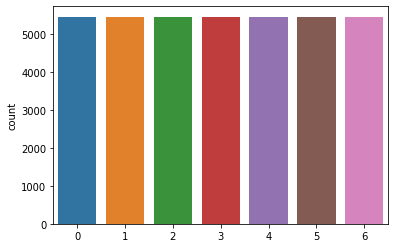

In [ ]:
sns.countplot(labels)

# Prepare words

In [ ]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, labels, test_size = 0.25, random_state=1000)

train_df = pd.concat([pd.Series(sentences_train, name='td'), pd.Series(y_train, name='labels')], axis=1)
test_df = pd.concat([pd.Series(sentences_test, name='td'), pd.Series(y_test, name='labels')], axis=1)

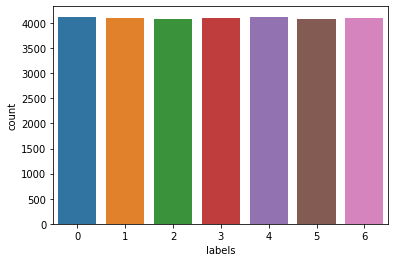

In [ ]:
sns.countplot(data=train_df, x='labels')

# Model

In [ ]:
# model = ClassificationModel('bert', 'bert-base-multilingual-cased', num_labels=len(LABELS), 
#                               args={'learning_rate':1e-5, 
#                                     'num_train_epochs': 30, 
#                                     'reprocess_input_data': True,
#                                     'overwrite_output_dir': True, 
#                                     'save_model_every_epoch': False, 
#                                     'save_steps': 5000}
#                               )


In [ ]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

In [ ]:
def plot_cm(y_true, y_pred, dir):
  plt.figure(figsize=(8,6))
  cm=confusion_matrix(y_true, y_pred, labels=range(len(LABELS)) )
  sns.heatmap(cm, xticklabels=range(len(LABELS)), yticklabels=range(len(LABELS)), annot=True, cmap='Blues', fmt='')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.savefig(f'{dir}/confusion-matrix.jpg')
  plt.show()
  plt.close()

In [ ]:
def make_cls_df(y_test, y_pred):
  cls=classification_report(y_test, y_pred, output_dict=True)
  cls_df=pd.DataFrame(cls)
  
  # cls_df.columns=[*LABELS, 'accuracy', 'macro avg', 'weighted avg']
  return cls_df.T

In [ ]:
def log_metrics(y_true, y_pred, dir):
  metrics=make_cls_df(y_true, y_pred)
  return metrics.to_csv(f'{dir}/metrics.csv')

In [ ]:
def plot_pr(y_test, predictions, cols, dir):
    n_rows = 2
    n_cols = 4 
 
    def plot_auc_one(y_i_test, predictions_i, label, ax):
      precision, recall, thresholds = precision_recall_curve(y_i_test, predictions_i)
      pr_auc=auc(recall, precision)
      ax.plot(recall, precision, marker='.', label='Precision-Recall', color='g', alpha=0.7)
      ax.set_title(f'{label[:12]}\n pr_auc=%.3f' % (pr_auc),  {'fontsize' : '18'})
 
    fig,axs=plt.subplots(n_rows, n_cols, figsize=(28,8))
    
    for i in range(y_test.shape[1]):
      plot_auc_one(y_test[:, i], predictions[:, i],  cols[i], axs[i//n_cols,i%n_cols])
 
    for i in range(len(cols), n_rows * n_cols):
      fig.delaxes(axs[i//n_cols, i%n_cols])
    
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig(f'{dir}/pr-curve.jpg')
    plt.show()
    plt.close()
 
def plot_roc(y_test, predictions, cols, dir):
    n_rows = 2
    n_cols = 4
 
    def plot_auc_one(y_i_test, predictions_i, label, ax):
      fpr,tpr,thresholds = roc_curve(y_i_test, predictions_i)
      try:
        roc_auc=roc_auc_score(y_i_test, predictions_i)
      except ValueError:
        roc_auc=1.0
 
      ax.plot(fpr, tpr, marker='.', label='ROC', color='r', alpha=0.7)
      ax.set_title(f'{label[:12]}\n roc_auc=%.3f' % (roc_auc),  {'fontsize' : '18'})
 
    fig,axs=plt.subplots(n_rows, n_cols, figsize=(28,8))
    
    for i in range(y_test.shape[1]):
      plot_auc_one(y_test[:, i], predictions[:, i],  cols[i], axs[i//n_cols,i%n_cols])
 
    for i in range(len(cols), n_rows * n_cols):
      fig.delaxes(axs[i//n_cols, i%n_cols])
    
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig(f'{dir}/roc-curve.jpg')
    plt.show()
    plt.close()

In [ ]:
def plot_auc(y_test, y_pred, dir):
  lb = LabelBinarizer()
  y_pred_lb = lb.fit_transform(y_pred)
  y_test_lb = lb.transform(y_test)

  plot_pr(y_test_lb, y_pred_lb, LABELS, dir)
  plot_roc(y_test_lb, y_pred_lb, LABELS, dir)

In [ ]:
def run_pipeline(train_df, test_df, epochs=20, earlystopping=True, evaluate=True, model_name='roberta', model_type='roberta-base'):

  suffix=datetime.now().strftime("%Y%m%d-%H%M%S")
  mname=f'models/tf_{model_type}_{suffix}'
  args = ClassificationArgs()

  if earlystopping:
    args.use_early_stopping = True
    args.early_stopping_delta = 0.001
    args.early_stopping_metric = "mcc"
    args.early_stopping_metric_minimize = False
    args.early_stopping_patience = 3

  if evaluate:
    args.evaluate_during_training_steps = 1000
    args.evaluate_during_training=True
    args.evaluate_during_training_verbose=True

  args.learning_rate = 1e-5
  args.num_train_epochs = epochs

  args.reprocess_input_data = True
  args.output_dir = mname
  args.overwrite_output_dir = True
  args.save_best_model = True
  args.save_model_every_epoch = False
  args.save_steps = 5000000
  args.best_model_dir = mname
  args.wandb_project = 'wand_vis'

  
  
  model = ClassificationModel(model_name, model_type, num_labels=len(LABELS), args=args)   
  model.train_model(train_df, eval_df=test_df, mcc=matthews_corrcoef, acc=accuracy_score, f1=f1_multiclass)

  x_test = test_df['td'].to_list()
  y_test = test_df['labels'].values

  y_pred, raw_outputs = model.predict(x_test)

  plot_cm(y_test, y_pred, mname)
  log_metrics(y_test, y_pred, mname)
  plot_auc(y_test, y_pred, mname)

  pd.concat([pd.Series(sentences_test, name='td'), pd.Series(y_test, name='true'), pd.Series(y_pred, name='pred')], axis=1).to_csv(f'{mname}/out.csv')

  print(matthews_corrcoef(y_test, y_pred))


In [ ]:
# run_pipeline(train_df, test_df, epochs=20, evaluate=True, model_name='bert', model_type='bert-base-multilingual-cased')
# run_pipeline(train_df, test_df, epochs=20, evaluate=True, model_name='roberta', model_type='roberta-base')
run_pipeline(train_df, test_df, epochs=20, evaluate=True, model_name='xlnet', model_type='xlnet-base-cased')
# run_pipeline(train_df, test_df, epochs=5, evaluate=True, model_name='zer0sh0t', model_type='programmer_ai_v2')

KeyError: ignored